# Essentials Notebook
This notebook provides most important and must have tools for early stage analysis.
It allows to quickly verify reward function and identify potential problems.

Analysis is divided into 2 sections:
- Vehicle Behaviour
- Reward Properties

There are few code explanations, because it is assumed, that you have already visited *Training_analysis* notebook and have some knowledge about parameters described here. Non standard implementations are documented.

## Import modules

In [1]:
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from deepracer.tracks import TrackIO, Track
from deepracer.logs import CloudWatchLogs as cw, \
    SimulationLogsIO as slio, \
    AnalysisUtils as au, \
    PlottingUtils as pu

## Load track

In [2]:
!ls tracks/

AmericasGeneratedInclStart.npy	New_York_Eval_Track.npy
AWS_track.npy			New_York_Track.npy
Bowtie_track.npy		Oval_track.npy
Canada_Eval.npy			reInvent2019_track.npy
Canada_Training.npy		reInvent2019_wide_mirrored.npy
China_eval_track.npy		reInvent2019_wide.npy
China_track.npy			reinvent_base.npy
FS_June2020.npy			Spain_track.npy
H_track.npy			Straight_track.npy
LGSWide.npy			Tokyo_Training_track.npy
London_Loop_Train.npy		Vegas_track.npy
Mexico_track_eval.npy		Virtual_May19_Train_track.npy
Mexico_track.npy


In [3]:
tu = TrackIO()

In [4]:
track = tu.load_track("reInvent2019_track")

Loaded 155 waypoints


In [5]:
def plot_track(t, fig=None):
    ratio = (lambda x,y: x / y)(*t.size())
    if fig is None:
        fig = plt.figure(figsize=(16,8))
    ax = fig.add_subplot()
    ax.axis('equal')
    ax.plot(*t.center_line.T, 'b')
    ax.plot(*t.outer_border.T, 'b')
    ax.plot(*t.inner_border.T, 'b')
    return ax

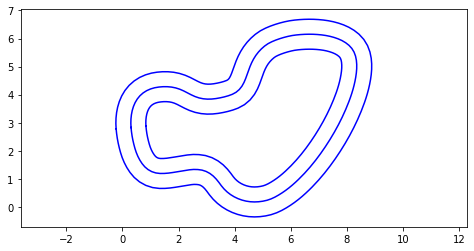

In [6]:
fig = plt.figure(figsize=(8,4))
ax = plot_track(track, fig)

In [7]:
def track_dheading(waypoints, N=2):
    """
    Calculate track waypoints heading in radians.
    N : waypoint look ahead
    """
    shifted = np.concatenate([waypoints[N:], waypoints[:N]])
    diff = shifted - waypoints
    t_heading = np.arctan2(diff.T[1], diff.T[0])
    dh = t_heading[1:] - t_heading[:-1]
    a = dh > math.pi
    b = dh < -math.pi
    dh[a] = dh[a] - 2*math.pi
    dh[b] = dh[b] + 2*math.pi
    return dh

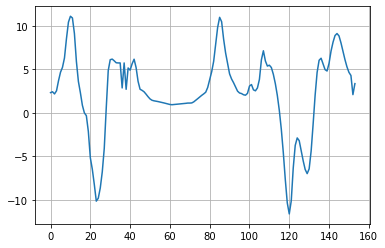

In [8]:
est_steering = np.degrees(track_dheading(track.center_line))
plt.plot(np.arange(len(est_steering)), est_steering)
plt.grid()

### Opposite direction
This code should be run to get estimated mean steering if trained with alternative direction parameter.

Such training runs agent in both directions changing heading every car reset.

In [9]:
inv_steering = np.array(list(reversed(est_steering)))
inv_steering *= -1
est_steering = (est_steering + inv_steering) / 2

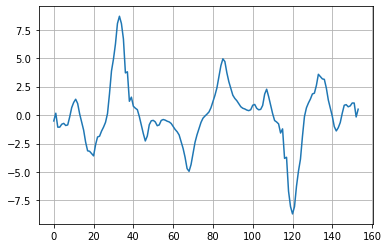

In [10]:
plt.plot(np.arange(len(est_steering)), est_steering)
plt.grid()

## Load log

In [11]:
stream_name = 'TTS-zeta' ## CHANGE This to your simulation application ID
fname = 'logs/deepracer-%s.log' %stream_name  # The log will be downloaded into the specified path

In [12]:
cw.download_log(fname, stream_prefix=stream_name)  # add force=True if you downloaded the file before but want to repeat

Log file exists, use force=True to download again


In [13]:
EPISODES_PER_ITERATION = 30 #  Set to value of your hyperparameter in training

data = slio.load_data(fname)
df = slio.convert_to_pandas(data, episodes_per_iteration=EPISODES_PER_ITERATION)

df = df.sort_values(['episode', 'steps'])

In [14]:
df

,iteration,episode,steps,x,y,yaw,steer,throttle,action,reward,done,on_track,progress,closest_waypoint,track_len,timestamp
0,1,0,3,0.3341,2.6047,-83.2172,15.0,1.7,5.0,1.0918,0,True,0.9838,2,23.12,1592683694.859099
1,1,0,4,0.3393,2.5667,-82.9928,-3.0,1.9,2.0,1.0809,0,True,1.1497,2,23.12,1592683694.9489803
2,1,0,5,0.3486,2.4992,-82.6783,15.0,1.7,5.0,1.1475,0,True,1.4441,2,23.12,1592683695.0340729
3,1,0,6,0.3573,2.4386,-82.3638,30.0,1.4,6.0,1.1321,0,True,1.7086,3,23.12,1592683695.1190882
4,1,0,7,0.3655,2.3898,-81.8189,30.0,1.4,6.0,1.1062,0,True,1.9227,3,23.12,1592683695.2090285
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127705,34,1019,196,0.7145,1.3457,148.4471,-30.0,1.4,0.0,1.2996,0,True,98.4652,144,23.12,1592700732.2819338
127706,34,1019,197,0.6404,1.4229,140.3814,-30.0,1.4,0.0,1.3409,0,True,98.8858,145,23.12,1592700732.3876975
127707,34,1019,198,0.5895,1.4927,133.6695,-3.0,1.9,2.0,1.2729,0,True,99.1931,145,23.12,1592700732.4611013
127708,34,1019,199,0.5388,1.5872,125.0550,-30.0,1.4,0.0,1.3681,0,True,99.6554,146,23.12,1592700732.5828068


# Vehicle Behaviour
## Action distribution
More even the distribution is the better the action space is matched with the track. Also can detect not used actions.

In [15]:
df['action'].value_counts().sort_index()

0.0    16518
1.0    25965
2.0    23385
3.0    10176
4.0    14053
5.0    21370
6.0    16243
Name: action, dtype: int64

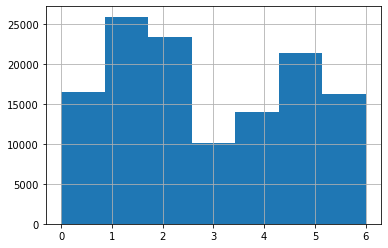

In [16]:
df['action'].hist(bins=int(df['action'].max() + 1))

-30.0    16518
-15.0    25965
-3.0     23385
 0.0     10176
 3.0     14053
 15.0    21370
 30.0    16243
Name: steer, dtype: int64

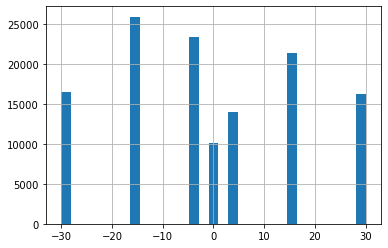

In [18]:
df['steer'].hist(bins=31)
df['steer'].value_counts().sort_index()

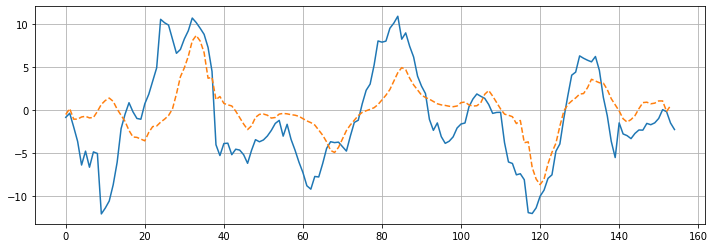

In [19]:
mean_steer = df[['steer', 'closest_waypoint']].groupby(by='closest_waypoint').mean()
plt.figure(figsize=(12,4))
plt.plot(mean_steer)
plt.plot(est_steering, '--')
plt.grid()

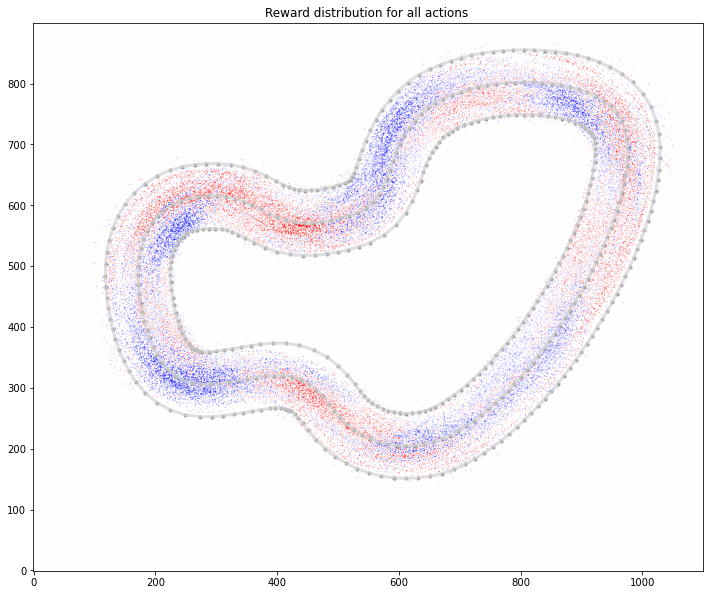

<Figure size 432x288 with 0 Axes>

In [20]:
pu.plot_track(df, track, value_field='steer', margin=1, cmap='bwr')

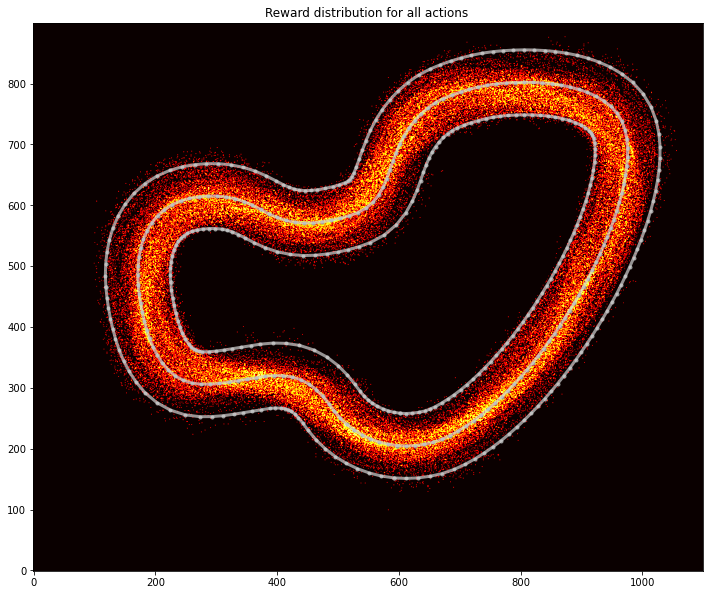

<Figure size 432x288 with 0 Axes>

In [21]:
pu.plot_track(df, track, value_field='throttle', margin=1)

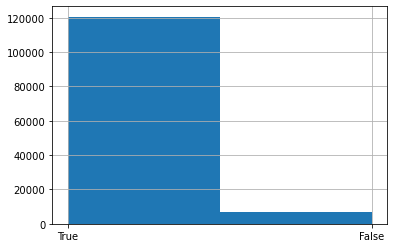

In [22]:
df['on_track'].hist(bins=2)

## Progress per steps
The higher the value the better.

In [23]:
pps = df['progress'].values / (1 + df['steps'].values)
df['pps'] = np.where(pps < 0.0, 0.0, pps)

In [24]:
sample = df[df['pps'] < 1.0]

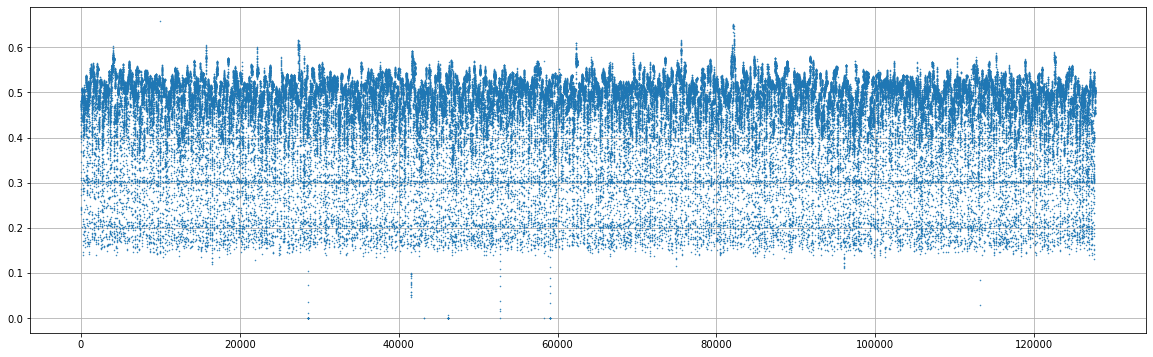

In [28]:
plt.figure(figsize=(20,6))
plt.plot(np.arange(0,len(sample)), sample['pps'], '.', markersize=1)
plt.grid()

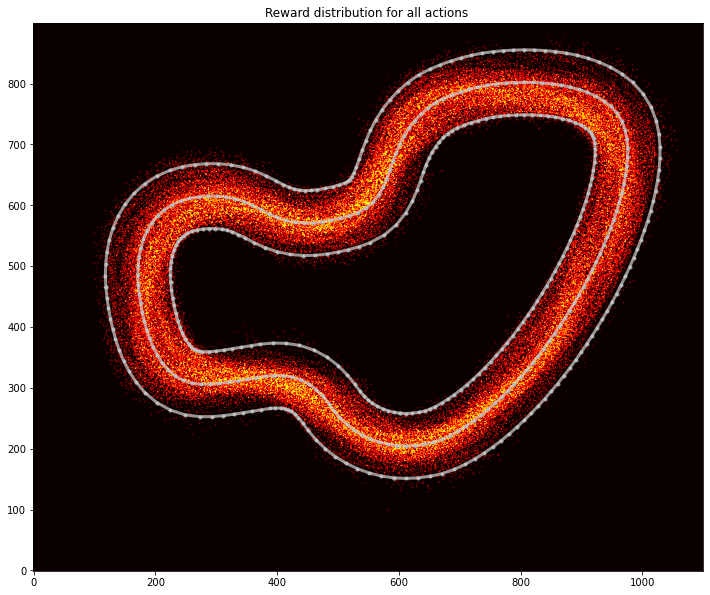

<Figure size 432x288 with 0 Axes>

In [26]:
pu.plot_track(sample, track, value_field='pps', margin=1)

In [27]:
df[['steps', 'progress']].corr()

,steps,progress
steps,1.00000,0.99622
progress,0.99622,1.00000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fcbb6611430>,
      dtype=object)

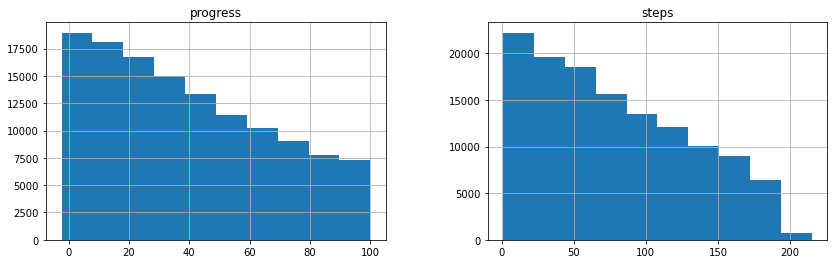

In [29]:
df[['steps', 'progress']].hist(figsize=(14,4))

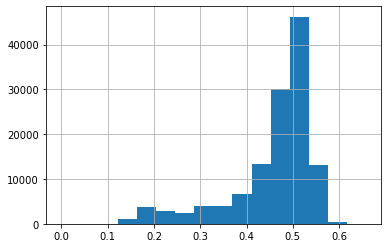

In [30]:
df['pps'].hist(bins=16)

## Progress and progress tempo
Tempo is the track distance covered in a single step.

> **NOTE** that it is calculated from progress so zig-zag does not count. We care only about distance covered towards the finish line.

The higher the value the better progress car is making.

In [31]:
def tempo(progress):
    result = np.zeros(len(progress))
    last = 0.0
    for x in range(0,len(progress)):
        d = 0.0
        p = progress[x] / 100.0
        if last < p:
            d = p - last
        result[x] = d
        last = max(float(p), 0.0)
    return result

In [32]:
# Logarithmic progress for increased contrast (subject to change if a better method of contrast increase is developed)
df['log_progress'] = [math.log(1.0 + max(r['progress'],0.0) / 10.0) for _,r in df.iterrows()]

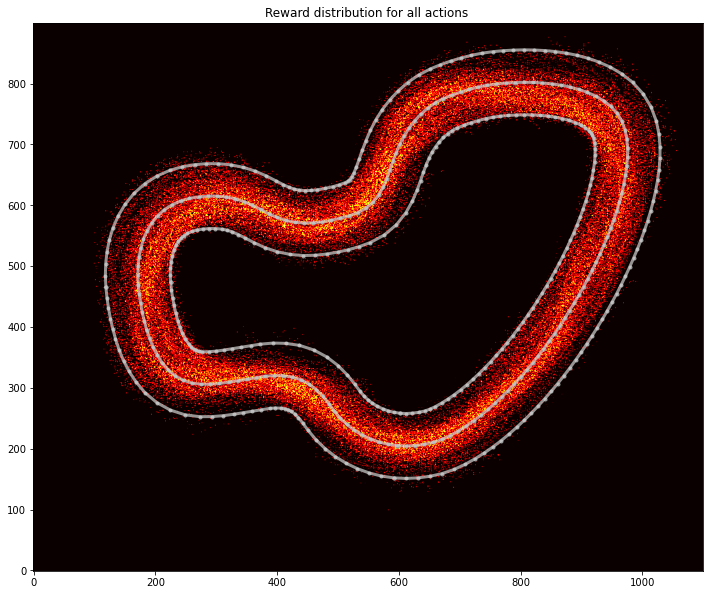

<Figure size 432x288 with 0 Axes>

In [33]:
pu.plot_track(df, track, value_field='log_progress', margin=1)

In [34]:
df['tempo'] = tempo(df['progress']) * df['track_len'][0]

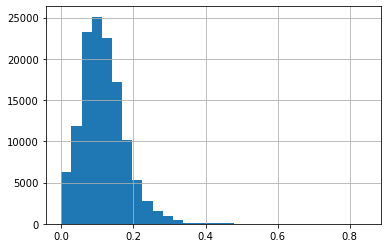

In [35]:
df['tempo'].hist(bins=30)

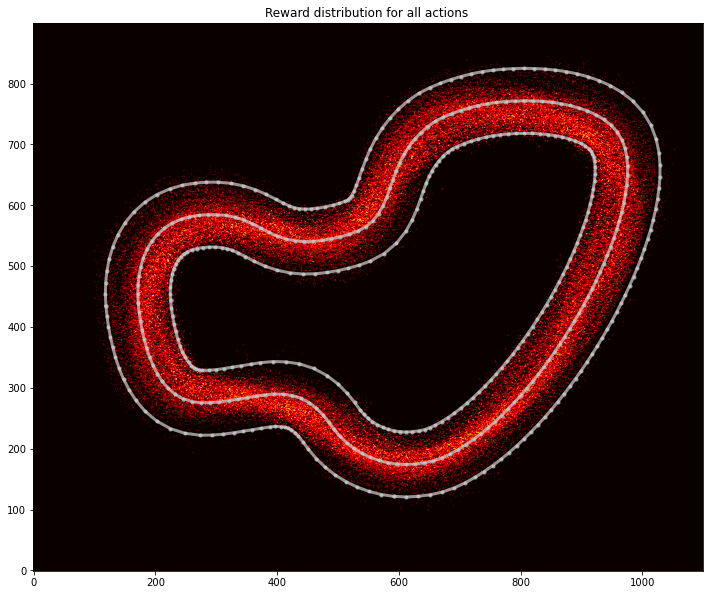

<Figure size 432x288 with 0 Axes>

In [36]:
pu.plot_track(df[df['tempo'] < 0.25], track, value_field='tempo')

# Training Metrics
Plot metrics with a console like plot.

> Keep in mind that there are no logs from evaluation runs, so you cannot see them here like you do inside AWS Console. Training episode progress is usually much worse because of the entropy that puts the car in unexcpected states.

In [37]:
metrics = df[['iteration','episode','reward','tempo']].copy()
metrics = metrics.groupby(by=['iteration','episode']).sum()
metrics.loc[:,'tempo'] = metrics.loc[:,'tempo'].values * 100 / df['track_len'][0]
iter_metrics = metrics[['reward','tempo']].groupby(by='iteration').mean()

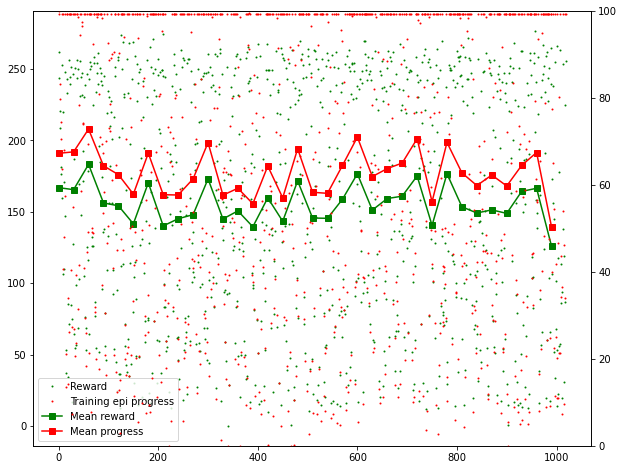

In [38]:
epi = np.arange(len(metrics))
it = np.arange(epi.min(), epi.max(), EPISODES_PER_ITERATION)
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot()
axp = ax.twinx()
axp.set_ylim((0,100))
d1 = ax.plot(epi, metrics['reward'].values, 'g.', markersize=2)
d2 = axp.plot(epi, metrics['tempo'].values, 'r.', markersize=2)
d3 = ax.plot(it, iter_metrics['reward'].values, 'g-s')
d4 = axp.plot(it, iter_metrics['tempo'].values, 'r-s')
data = d1 + d2 + d3 + d4
ax.legend(data, ['Reward', 'Training epi progress', 'Mean reward', 'Mean progress'])

# Reward Properties
Analyze returned reward, apply different rewards for comparison.

## Helper definitions

In [89]:
def df2params(frame, track: Track, mapping=None):
    if mapping is None:
        mapping = {'on_track':'all_wheels_on_track', 'throttle':'speed',
                   'yaw':'heading', 'steer':'steering_angle', 'track_len':'track_length', 'progress':'progress', 'steps':'steps',
                  'x':'x', 'y':'y', 'distance_from_center':'distance_from_center'}
    d = {'closest_waypoints': [frame['closest_waypoint'], (frame['closest_waypoint']+1)%len(track.center_line)]}
    width = np.linalg.norm(track.inner_border[0] - track.outer_border[0])
    d.update({'is_reversed':False, 'waypoints':track.center_line, 'track_width':width})
    d.update({mapping[k]:frame[k] for k in mapping})
    return d

In [90]:
import importlib

### Estimate missing parameters

In [91]:
def dist_from_center(row, waypoints):
    "Adds missing distance_from_center column"
    close = row['closest_waypoint']
    estimated = np.array(waypoints[close])
    pos = np.array([row['x'], row['y']])
    dist = np.linalg.norm(pos - estimated)
    return dist

In [92]:
df['distance_from_center'] = [dist_from_center(r, track.center_line) for _,r in df.iterrows()]

## Apply different reward

In [152]:
name = 'adversarial'
reward = importlib.import_module('rewards.{0}'.format(name))
# Reload module so it is always up to date
importlib.reload(reward)
reward_function = reward.reward_function

In [153]:
original = 'reward'
# Recalculate log can be unncessary because we use original value from memory
if 'log_'+original not in df.columns:
    df['log_' + original] = [math.log(1 + r[original]) for _,r in df.iterrows()]

In [154]:
df[name] = [reward_function(df2params(r, track)) for _,r in df.iterrows()]
df['log_' + name] = [math.log(1 + r[name]) for _,r in df.iterrows()]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fcc49fb1520>,
      dtype=object)

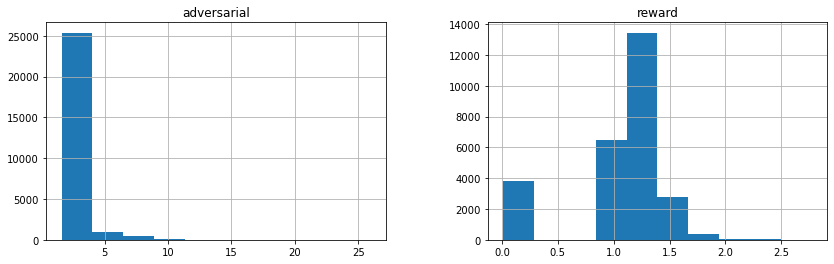

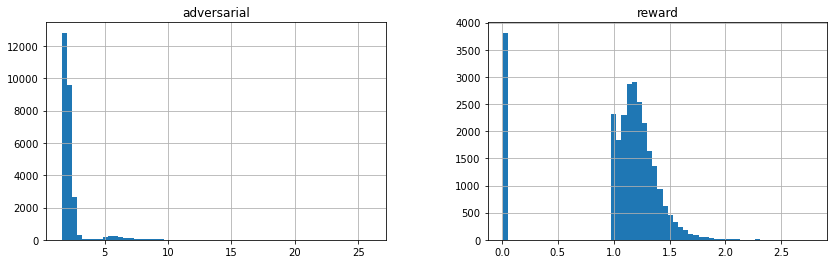

In [155]:
df[[original, name]].hist(figsize=(14,4))
df[[original, name]].hist(figsize=(14,4), bins=60)

In [156]:
df[[original, name]].describe()

,reward,adversarial
count,26943.000000,26943.000000
mean,1.052254,2.343517
std,0.451028,1.382984
min,0.010000,1.614048
25%,1.038200,1.845289
50%,1.166900,2.038448
75%,1.288000,2.293176
max,2.772800,25.933158


Text(0.5, 1.0, 'adversarial')

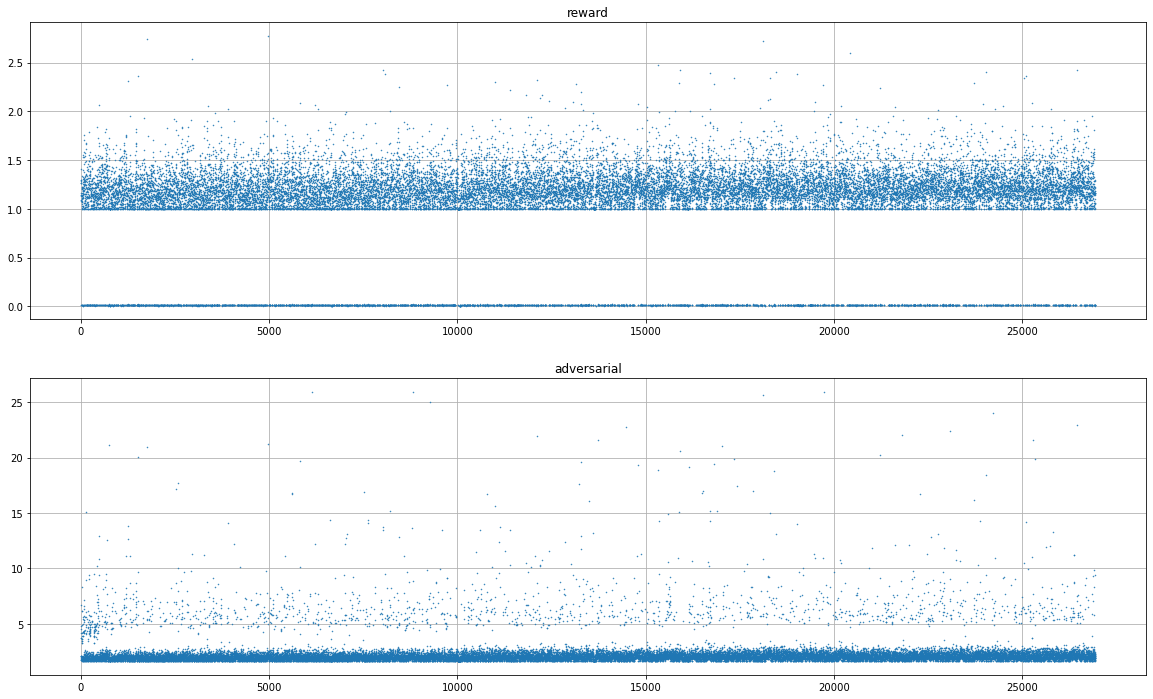

In [157]:
plt.figure(figsize=(20,12))

plt.subplot(2,1,1)
plt.plot(df.index, df[original], '.', markersize=1)
plt.grid()
plt.title(original)

plt.subplot(2,1,2)
plt.plot(df.index, df[name], '.', markersize=1)
plt.grid()
plt.title(name)

In [158]:
sample = df.sample(frac=0.75)
#sample = df[df[name] < 8]

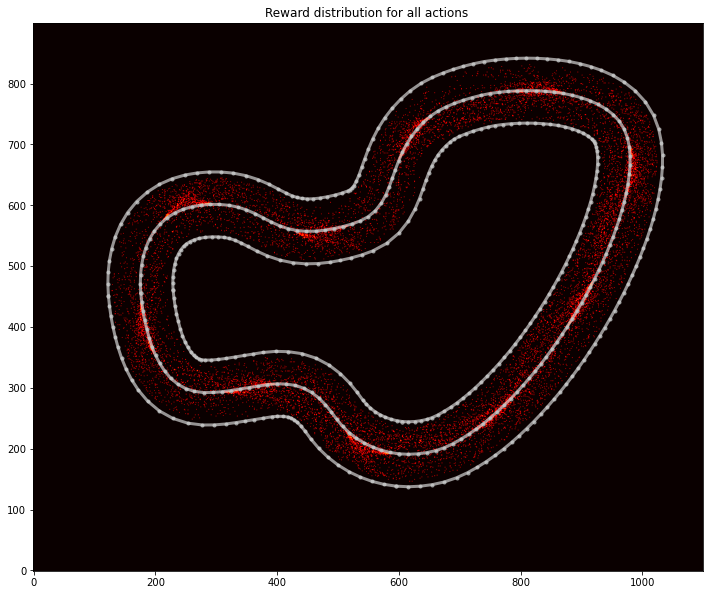

<Figure size 432x288 with 0 Axes>

In [159]:
pu.plot_track(sample, track, value_field='log_{0}'.format(original))

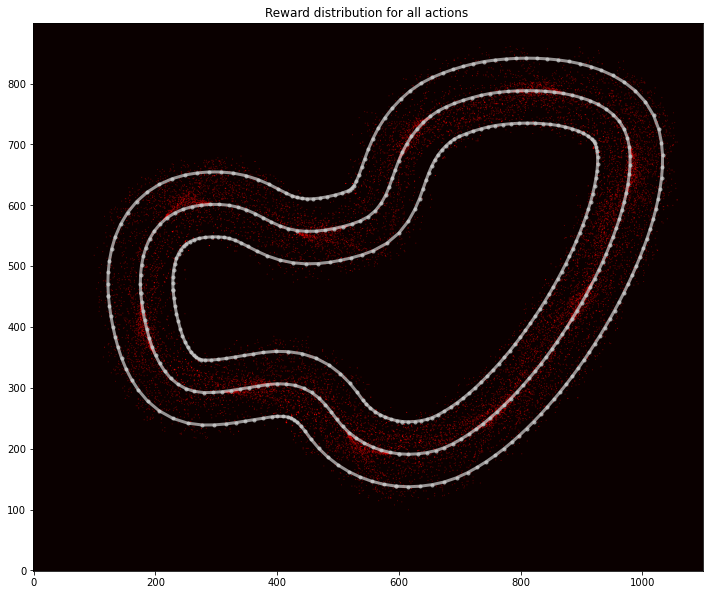

<Figure size 432x288 with 0 Axes>

In [160]:
pu.plot_track(sample, track, value_field='log_{0}'.format(name))

## Plot saved sectors
If your last computed reward function implements sectors global variable storing model records, you can plot it here.

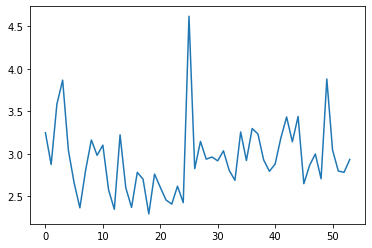

In [161]:
sectors = pd.DataFrame([(a[0],a[1],b) for a,b in reward.sectors.items()], columns=['x', 'y', 'var'])
plt.plot(sectors.index, sectors['var'])

# Bonus : Visualize reward

## Compare functions
Choose your warrior wisely. Your function needs improvement? Incorrect distribution? Don't worry! Let's see which function does suit your needs best!

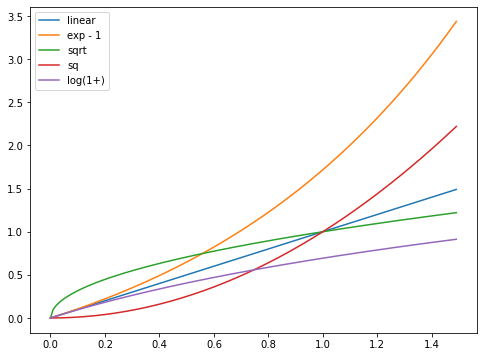

In [72]:
ox = np.arange(0,1.5,0.01)
plt.figure(figsize=(8,6))
plt.plot(ox, ox)
plt.plot(ox, np.exp(ox) - 1)
plt.plot(ox, np.sqrt(ox))
plt.plot(ox, np.power(ox, 2.0))
plt.plot(ox, np.log(1 + ox))
plt.legend(['linear','exp - 1','sqrt','sq','log(1+)'])

## Plot reward distribution

Here we create heatmaps with reward distribution along 2 parameters of choice.

In [149]:
def plot3d_reward(x, y, rewardf):
    "Plot rewardf(x,y) reward to visualize reward resoponse on x,y parameters change"
    X,Y = np.meshgrid(x, y)
    Z = np.zeros(X.shape)
    # ideally array should be passed into the reward, but some rewards use functions from math library, which is incompatible with numpy arrays
    # to solve this problem we calculate reward iteratively
    for r in range(0,Z.shape[0]):
        for c in range(0,Z.shape[1]):
            Z[r,c] = rewardf(X[r,c], Y[r,c])
    sns.heatmap(Z)

In [140]:
def updated_params(params, **kwargs):
    p = dict(params)
    p.update(kwargs)
    return p

In [141]:
src = df.sample(n=1)
src

,iteration,episode,steps,x,y,yaw,steer,throttle,action,reward,...,timestamp,pps,log_progress,tempo,distance_from_center,log_reward,adversarial,log_adversarial,heading,log_heading
20091,25,726,14,6.8692,0.9468,22.0251,-30.0,1.4,0.0,0.014,...,1592657187.875394,0.3289,0.401022,0.164244,0.458205,0.013903,1.130547,0.756379,0.280426,0.247193


In [142]:
params = df2params(src.iloc[0], track)
rew = lambda x, y: reward_function(updated_params(params, distance_from_center=x, heading=y))

In [150]:
X = np.arange(0.0, params['track_width'], 0.01)
Y = np.arange(-180, 180, 0.5)

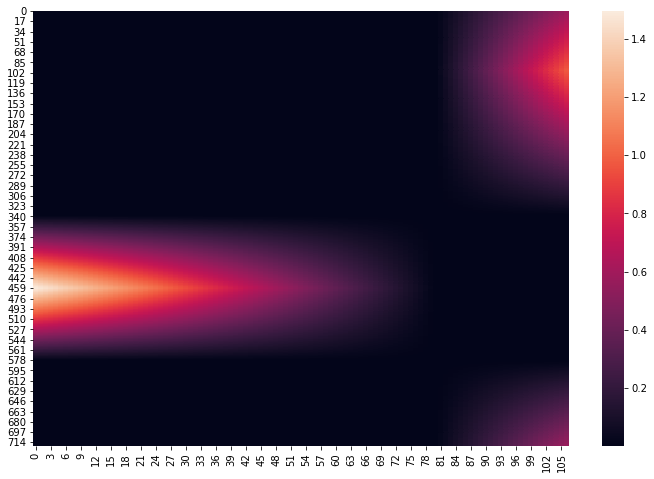

In [151]:
fig = plt.figure(figsize=(12,8))
plot3d_reward(X, Y, rew)